# Compute Homeomorphism on Circle

## Find Diffeomorphic Flow via Functional Invariance and Vector Field Invariance

In [10]:
from tqdm.notebook import tqdm
import torch

STATE_DIM = 2
LAMBDA = torch.tensor(2.0)
RHO = torch.tensor(0.5)
GOAL_STATE = torch.tensor([1, 0])

def symmetry_group(theta):
    return torch.stack([
        torch.stack([torch.cos(theta), -torch.sin(theta)], dim=-1),
        torch.stack([torch.sin(theta), torch.cos(theta)], dim=-1)
    ], dim=-2)  # Shape: (batch_size, 2, 2)

def reward_func(state):
    cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=torch.float32)
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

def compute_flow(H, g):
    return H @ g @ torch.inverse(H)

STATE_SPACE_LOW = -2
STATE_SPACE_HIGH = 2
GROUP_SPACE_LOW = 0
GROUP_SPACE_HIGH = 2 * torch.pi

H_oracle = torch.tensor([
    [1 / torch.sqrt(LAMBDA.to(dtype=torch.float32)), 0],
    [0, 1 / torch.sqrt(RHO.to(dtype=torch.float32))]
], requires_grad=True)

class DiffeomorphicFlow():
    def __init__(self, 
                 H_inits: torch.tensor,
                 symmetry_group: callable,
                 reward_function: callable,
                 differential_generator: torch.tensor,
                 kernel_distribution: torch.tensor,
                 sample_size: int,
                 n_epochs: int,
                 n_runs: int,
                 func_learning_args: dict = {'lr': 0.0005, "step_size": None, "gamma": None},
                 vec_field_learning_args: dict = {'lr': 0.0005, "step_size": None, "gamma": None},
                 lambda_coeff: float = 0.0,
                 H_oracle: torch.tensor = None,
                 state_dim = 2,
                 state_space_high = 2,
                 state_space_low = -2,
                 group_space_high = 2 * torch.pi,
                 group_space_low = 0,
                 verbose: bool = False):
        """Computes a diffeomorphism that makes a reward function invariant to a symmetry group using functional and vector field invariance."""

        self.H_inits = H_inits
        self.symmetry_group = symmetry_group
        self.reward_function = reward_function
        self.differential_generator = differential_generator
        self.kernel_distribution = kernel_distribution
        self.lambda_coeff = lambda_coeff
        self.H_oracle = H_oracle
        self.n_epochs = n_epochs
        self.n_runs = n_runs
        self.func_learning_args = func_learning_args
        self.vec_field_learning_args = vec_field_learning_args
        self._sample_size = sample_size
        self._verbose = verbose
        self.state_dim = state_dim
        self.state_space_high = state_space_high
        self.state_space_low = state_space_low
        self.group_space_high = group_space_high
        self.group_space_low = group_space_low

        self._optimizer_func = None

    def reset_parameters(self,
                         H_0: torch.tensor = None):
        """Resets the Diffeomorphisms to H_0."""

        self.H_func_inv = torch.nn.Parameter(H_0.clone().detach().requires_grad_(True))
        self.H_vec_field = torch.nn.Parameter(H_0.clone().detach().requires_grad_(True))

        if self._optimizer_func is not None:
            del self._optimizer_func, self._optimizer_vec_field, self.scheduler_func, self.scheduler_vec_field
        self._optimizer_func = torch.optim.Adam([self.H_func_inv], lr=self.func_learning_args["lr"])
        self._optimizer_vec_field = torch.optim.Adam([self.H_vec_field], lr=self.vec_field_learning_args["lr"])

        if self.func_learning_args["step_size"] is not None:
            self.scheduler_func = torch.optim.lr_scheduler.StepLR(self._optimizer_func, step_size=self.func_learning_args["step_size"], gamma=self.func_learning_args["gamma"])
        else:
            self.scheduler_func = None
        if self.vec_field_learning_args["step_size"] is not None:
            self.scheduler_vec_field = torch.optim.lr_scheduler.StepLR(self._optimizer_vec_field, step_size=self.func_learning_args["step_size"], gamma=self.func_learning_args["gamma"])
        else:
            self.scheduler_vec_field = None


    def compute_diffeomorphic_flow(self,
                                   H: torch.tensor,
                                   flow: torch.tensor) -> torch.tensor:
        """Given a flow and a diffeomorphism H, computes H \circ flow \circ H^-1."""
        return H @ flow @ torch.inverse(H)


    def functional_optimization(self,
                                H: torch.tensor,
                                lambda_coeff: float,
                                take_gradient_step: bool,
                                states: torch.Tensor,
                                group_elements: torch.Tensor) -> float:
        """Takes one gradient step to computes a Diffeomorphism that makes the reward function invariant to the symmetry group using functional invariance. Adds a
        regularizer that drives the Homeo towards the identity matrix."""

        states = states.unsqueeze(-1)

        group_actions = self.symmetry_group(group_elements)

        H_expanded = H.unsqueeze(0)
        flow_matrices = self.compute_diffeomorphic_flow(H_expanded, group_actions)
        transformed_states = torch.einsum('bij,bjk->bik', flow_matrices, states)

        base_rewards = self.reward_function(states.squeeze(-1))
        transformed_rewards = self.reward_function(transformed_states.squeeze(-1))

        loss = torch.mean(torch.pow(base_rewards - transformed_rewards, 2)) + lambda_coeff * torch.norm(H - torch.eye(H.shape[0]))

        if take_gradient_step:
            self._optimizer_func.zero_grad()
            loss.backward()
            self._optimizer_func.step()

        return loss


    def vector_field_optimization(self,
                                  states: torch.tensor) -> float:
        
        def flow_func(vector_field):
            """Returns a function that applies a vector field to a state."""
            return lambda s: torch.matmul(vector_field, s)

        def compute_jacobian(f, s):
            """Compute a vectorized Jacobian of function f over a batch of states s."""
            return torch.vmap(torch.func.jacrev(f))(s)
        
        batch_size = states.shape[0]
        diffeo_flow = self.compute_diffeomorphic_flow(self.H_vec_field, self.differential_generator)

        # Compute vector fields at s
        batched_diffeo_vector_field = diffeo_flow.expand(batch_size, -1, -1)
        batched_kernel_dist = self.kernel_distribution.expand(batch_size, -1, -1)
        diffeo_vector_field = torch.bmm(batched_diffeo_vector_field, states.unsqueeze(-1))
        kernel_dist_vector_field = torch.bmm(batched_kernel_dist, states.unsqueeze(-1))

        # Compute Jacobians (vectorized)
        diffeo_callable = flow_func(diffeo_flow)
        kernel_callable = flow_func(self.kernel_distribution)

        J_diffeo = compute_jacobian(diffeo_callable, states)# .transpose(-1, -2)  # Shape: (batch_size, 2, 2), must be transposed due to jacrev
        J_kernel = compute_jacobian(kernel_callable, states)# .transpose(-1, -2)  # Shape: (batch_size, 2, 2), must be transposed due to jacrev

        # Compute Lie bracket: [X, Y] = J_X @ Y_vals - J_Y @ X_vals
        bracket = torch.bmm(J_diffeo, kernel_dist_vector_field) - torch.bmm(J_kernel, diffeo_vector_field)
        loss = torch.norm(bracket)

        self._optimizer_vec_field.zero_grad()
        loss.backward()
        self._optimizer_vec_field.step()

        return loss
    
    def take_one_step(self):
        """Take one gradient step via both functional and vector field invariance."""

        # Gradient based update
        states = torch.rand(self._sample_size, self.state_dim) * (self.state_space_high - self.state_space_low) + self.state_space_low
        group_elements = torch.rand(self._sample_size) * (self.group_space_high - self.group_space_low) + self.group_space_low

        _ = self.functional_optimization(self.H_func_inv, lambda_coeff=self.lambda_coeff, take_gradient_step=True, states=states, group_elements=group_elements)
        _ = self.vector_field_optimization(states=states)
        del states, group_elements

        # Evaluation
        eval_states = torch.rand(self._sample_size, self.state_dim) * (self.state_space_high - self.state_space_low) + self.state_space_low
        eval_group_elements = torch.rand(self._sample_size) * (self.group_space_high - self.group_space_low) + self.group_space_low
        
        loss_func = self.functional_optimization(self.H_func_inv, lambda_coeff=0, take_gradient_step=False, states=eval_states, group_elements=eval_group_elements)
        loss_vec_field = self.functional_optimization(self.H_vec_field, lambda_coeff=0, take_gradient_step=False, states=eval_states, group_elements=eval_group_elements)
        if self.H_oracle is not None:
            loss_oracle = self.functional_optimization(self.H_oracle, lambda_coeff=0, take_gradient_step=False, states=eval_states, group_elements=eval_group_elements)
        else:
            loss_oracle = torch.tensor(0.0)

        return loss_func, loss_vec_field, loss_oracle
    
    
    def optimize(self):

        self.loss_funcs = torch.zeros((self.n_runs, self.n_epochs))
        self.loss_vec_fields = torch.zeros((self.n_runs, self.n_epochs))
        self.loss_oracles = torch.zeros((self.n_runs, self.n_epochs))


        for idx_run in range(self.n_runs):
            self.reset_parameters(self.H_inits[idx_run])
            pbar = tqdm(range(self.n_epochs), desc=f'Run {idx_run + 1}/{self.n_runs}', dynamic_ncols=True, ascii=True)
            for idx_epoch in pbar:
                loss_func, loss_vec_field, loss_oracle = self.take_one_step()
                self.loss_funcs[idx_run, idx_epoch] = loss_func
                self.loss_vec_fields[idx_run, idx_epoch] = loss_vec_field
                self.loss_oracles[idx_run, idx_epoch] = loss_oracle

                if idx_epoch % 250 == 0:
                    pbar.set_postfix({
                        'func. inv loss': f'{loss_func:.4f}',
                        'vec. field inv loss': f'{loss_vec_field:.4f}',
                        'oracle loss': f'{loss_oracle:.4f}'
                    })

                if self.scheduler_func is not None:
                    self.scheduler_func.step()
                if self.scheduler_vec_field is not None:
                    self.scheduler_vec_field.step()    
            pbar.close()

In [11]:
LAMBDA = torch.tensor(2.0)
RHO = torch.tensor(0.5)
SAMPLE_SIZE = 25
N_EPOCHS = 25_000
N_RUNS = 3
H_0_HOW = "random"

def symmetry_group(theta):
    return torch.stack([
        torch.stack([torch.cos(theta), -torch.sin(theta)], dim=-1),
        torch.stack([torch.sin(theta), torch.cos(theta)], dim=-1)
    ], dim=-2)  # Shape: (batch_size, 2, 2)
def reward_func(state):
    cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=torch.float32)
    return -torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)
differential_generator = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
# kernel_distribution = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=torch.float32) #TODO, I believe this is wrong
kernel_distribution = torch.tensor([[0, -RHO], [LAMBDA, 0]], dtype=torch.float32)
H_oracle = torch.tensor([[1 / torch.sqrt(LAMBDA), 0], [0, 1 / torch.sqrt(RHO)]], dtype=torch.float32)

if H_0_HOW == "random":
    initial_Hs = [torch.randn((2,2), dtype=torch.float32) for _ in range(N_RUNS)]
elif H_0_HOW == "identity":
    initial_Hs = [torch.eye(2, dtype=torch.float32) for _ in range(N_RUNS)]       
elif H_0_HOW == "oracle":
    initial_Hs = [H_oracle.clone() for _ in range(N_RUNS)]

In [12]:
diffeo_flow = DiffeomorphicFlow(H_inits=initial_Hs,
                                symmetry_group=symmetry_group,
                                reward_function=reward_func,
                                differential_generator=differential_generator,
                                kernel_distribution=kernel_distribution,
                                sample_size=SAMPLE_SIZE,
                                n_epochs=N_EPOCHS,
                                n_runs=N_RUNS,
                                H_oracle=H_oracle)

diffeo_flow.optimize()

Run 1/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/25000 [00:00<?, ?it/s]

## Plotting

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Global settings for font size and tick size
TICK_SIZE = 20
LABEL_FONT_SIZE = 20
PLOT_ORACLE: bool = True
WINDOW_SIZE = 5

plt.rcParams.update({
    'xtick.labelsize': TICK_SIZE,
    'ytick.labelsize': TICK_SIZE,
    'axes.labelsize': LABEL_FONT_SIZE,
    'legend.fontsize': LABEL_FONT_SIZE
})

def compute_mean_and_std_losses(diffeo_flow, window_size):
    """"""

    def moving_average(arr, window_size):
        kernel = np.ones(window_size) / window_size
        return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=arr)
    
    def compute_mean_and_std_loss(losses):
        losses_np = losses.detach().numpy()
        mean_losses_smoothed = moving_average(losses_np, window_size).mean(axis=0)
        log_std_losses_smoothed = np.exp(np.std(np.log(moving_average(losses_np, WINDOW_SIZE) + 1e-8), axis=0))
        return mean_losses_smoothed, log_std_losses_smoothed
    
    loss_funcs = diffeo_flow.loss_funcs
    loss_vec_fields = diffeo_flow.loss_vec_fields
    loss_oracles = diffeo_flow.loss_oracles

    mean_loss_funcs, log_std_loss_funcs = compute_mean_and_std_loss(loss_funcs)
    mean_loss_vec_fields, log_std_loss_vec_fields = compute_mean_and_std_loss(loss_vec_fields)
    mean_loss_oracles, log_std_loss_oracles = compute_mean_and_std_loss(loss_oracles)

    losses = {}
    losses['loss_func'] = {}
    losses['loss_vec_field'] = {}
    losses['loss_oracle'] = {}

    losses['loss_func']['mean'] = mean_loss_funcs
    losses['loss_func']['log_std'] = log_std_loss_funcs
    losses['loss_vec_field']['mean'] = mean_loss_vec_fields
    losses['loss_vec_field']['log_std'] = log_std_loss_vec_fields
    losses['loss_oracle']['mean'] = mean_loss_oracles
    losses['loss_oracle']['log_std'] = log_std_loss_oracles

    return losses

def plot_losses(losses):

    plt.figure(figsize=(12, 8))
    loss_types = ['loss_func', 'loss_vec_field', 'loss_oracle']
    loss_names = ['Functional Invariance', 'Vector Field Invariance', 'Oracle']
    colors = ['blue', 'green', 'red']

    for idx_loss_type, loss_type in enumerate(loss_types):
        mean_losses = losses[loss_type]['mean']
        log_std_losses = losses[loss_type]['log_std']
        plt.plot(mean_losses, label=loss_names[idx_loss_type], color=colors[idx_loss_type])
        plt.fill_between(range(len(mean_losses)), mean_losses / log_std_losses, mean_losses * log_std_losses, alpha=0.2, color=colors[idx_loss_type])


    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

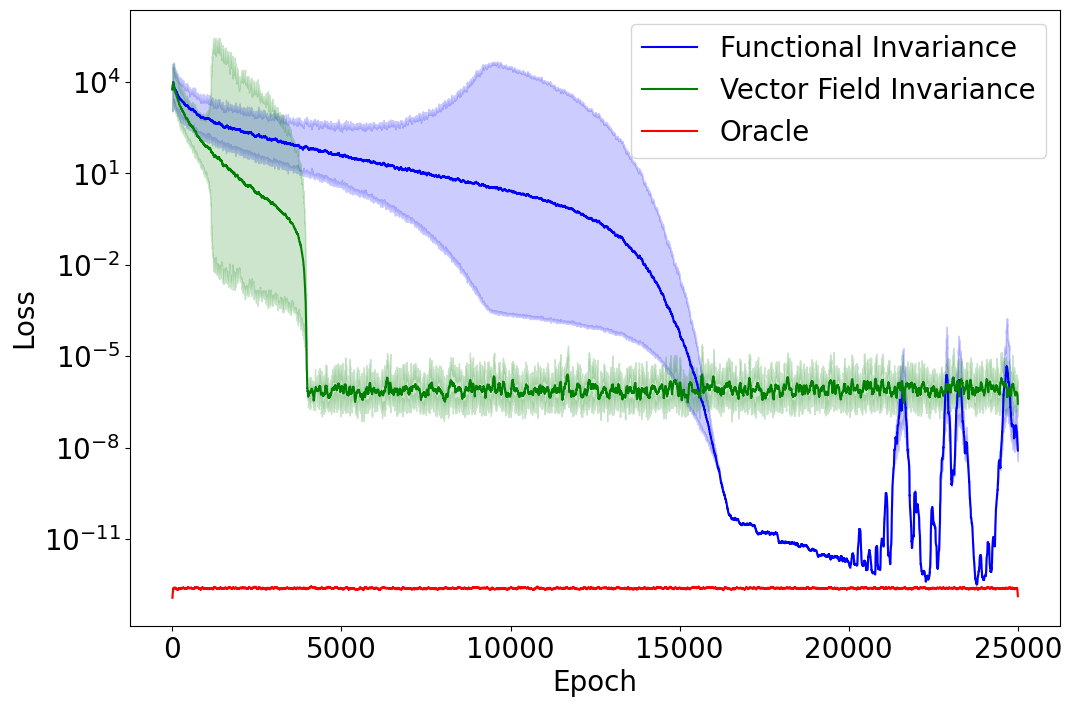

In [14]:
losses = compute_mean_and_std_losses(diffeo_flow, window_size=50)
plot_losses(losses)

# Ablations

In [8]:
import matplotlib.pyplot as plt

def plot_experiment_losses(losses, plot_func_inv: bool = True, plot_vec_field_inv: bool = True):
    """Plots losses of an experiment using different shades of blue for functional invariance
    and different shades of green for vector field invariance."""

    plt.figure(figsize=(12, 8))

    # Generate distinct shades of blue and green
    num_losses = len(losses)
    blue_colors = [plt.cm.Blues(0.3 + 0.7 * i / (num_losses - 1)) for i in range(num_losses)]
    green_colors = [plt.cm.Greens(0.3 + 0.7 * i / (num_losses - 1)) for i in range(num_losses)]

    for idx, (loss_key, loss_values) in enumerate(losses.items()):
        print(loss_key)
        if plot_func_inv:
            mean_losses = loss_values['loss_func']['mean']
            log_std_losses = loss_values['loss_func']['log_std']
            plt.plot(mean_losses, label=f"Func Inv, {loss_key}", color=blue_colors[idx])
            plt.fill_between(range(len(mean_losses)), mean_losses / log_std_losses, mean_losses * log_std_losses, alpha=0.2, color=blue_colors[idx])
        elif idx==0:
            mean_losses = loss_values['loss_func']['mean']
            log_std_losses = loss_values['loss_func']['log_std']
            plt.plot(mean_losses, label=f"Func Inv, {loss_key}", color=blue_colors[idx])
            plt.fill_between(range(len(mean_losses)), mean_losses / log_std_losses, mean_losses * log_std_losses, alpha=0.2, color=blue_colors[idx])

    for idx, (loss_key, loss_values) in enumerate(losses.items()):

        if plot_vec_field_inv:
            mean_losses = loss_values['loss_vec_field']['mean']
            log_std_losses = loss_values['loss_vec_field']['log_std']
            plt.plot(mean_losses, label=f"Vector Inv, {loss_key}", color=green_colors[idx])
            plt.fill_between(range(len(mean_losses)), mean_losses / log_std_losses, mean_losses * log_std_losses, alpha=0.2, color=green_colors[idx])
        elif idx==0:
            mean_losses = loss_values['loss_vec_field']['mean']
            log_std_losses = loss_values['loss_vec_field']['log_std']
            plt.plot(mean_losses, label=f"Vector Inv, {loss_key}", color=green_colors[idx])
            plt.fill_between(range(len(mean_losses)), mean_losses / log_std_losses, mean_losses * log_std_losses, alpha=0.2, color=green_colors[idx])            

    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Compare Different Learning Rate Arguments.

In [4]:
N_RUNS = 3
N_EPOCHS = 25_000
H_0_HOW = "random"
learning_args_func_list = [
    {"lr": 0.0005, "step_size": 5000, "gamma": 0.5},
    {"lr": 0.0005, "step_size": 5000, "gamma": 0.7},
    {"lr": 0.0005, "step_size": 5000, "gamma": 0.9}
    ]
learning_args_vec_field_list = [
    {"lr": 0.0005, "step_size": 100, "gamma": 0.2},
    {"lr": 0.0005, "step_size": 250, "gamma": 0.1},
    {"lr": 0.0005, "step_size": 500, "gamma": 0.2},
    ]


if H_0_HOW == "random":
    initial_Hs = [torch.randn((2,2), dtype=torch.float32) for _ in range(N_RUNS)]
elif H_0_HOW == "identity":
    initial_Hs = [torch.eye(2, dtype=torch.float32) for _ in range(N_RUNS)]       
elif H_0_HOW == "oracle":
    initial_Hs = [H_oracle.clone() for _ in range(N_RUNS)]

diffeo_flows_learning_configs = []

for learning_args_func, learning_args_vec_field in zip(learning_args_func_list, learning_args_vec_field_list):
    print(f"Running for learning args: {learning_args_func}")
    diffeo_flow = DiffeomorphicFlow(H_inits=initial_Hs,
                                    symmetry_group=symmetry_group,
                                    reward_function=reward_func,
                                    differential_generator=differential_generator,
                                    kernel_distribution=kernel_distribution,
                                    func_learning_args=learning_args_func,
                                    vec_field_learning_args=learning_args_vec_field,
                                    sample_size=SAMPLE_SIZE,
                                    n_epochs=N_EPOCHS,
                                    n_runs=N_RUNS,
                                    H_oracle=H_oracle)

    diffeo_flow.optimize()
    diffeo_flows_learning_configs.append(diffeo_flow)

Running for learning args: {'lr': 0.0005, 'step_size': 5000, 'gamma': 0.5}


Run 1/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Running for learning args: {'lr': 0.0005, 'step_size': 5000, 'gamma': 0.7}


Run 1/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Running for learning args: {'lr': 0.0005, 'step_size': 5000, 'gamma': 0.9}


Run 1/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/25000 [00:00<?, ?it/s]

learning_rate_config_0
learning_rate_config_1
learning_rate_config_2


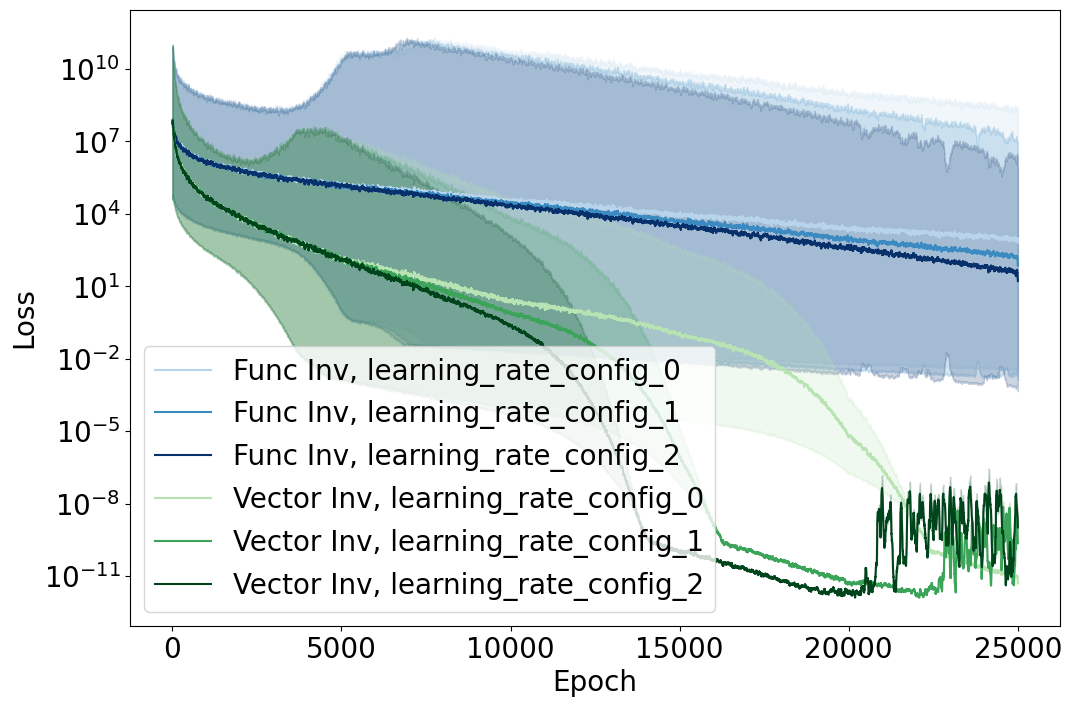

In [9]:
experiment_losses = {}
WINDOW_SIZE = 25

for idx, diffeo_flow in enumerate(diffeo_flows_learning_configs):
    losses = compute_mean_and_std_losses(diffeo_flow, WINDOW_SIZE)
    experiment_losses[f'learning_rate_config_{idx}'] = losses

plot_experiment_losses(experiment_losses, plot_func_inv=True, plot_vec_field_inv=True)

## Compare Different Regularization Coefficients for Functional Invariance.

In [4]:
LAMBDA_COEFFS = [0, 1, 10]
N_RUNS = 5
N_EPOCHS = 30_000
H_0_HOW = "random"

if H_0_HOW == "random":
    initial_Hs = [torch.randn((2,2), dtype=torch.float32) for _ in range(N_RUNS)]
elif H_0_HOW == "identity":
    initial_Hs = [torch.eye(2, dtype=torch.float32) for _ in range(N_RUNS)]       
elif H_0_HOW == "oracle":
    initial_Hs = [H_oracle.clone() for _ in range(N_RUNS)]

diffeo_flows = []

for lambda_coeff in LAMBDA_COEFFS:
    print(f"Running for lambda coeff: {lambda_coeff}")
    diffeo_flow = DiffeomorphicFlow(H_inits=initial_Hs,
                                    symmetry_group=symmetry_group,
                                    reward_function=reward_func,
                                    differential_generator=differential_generator,
                                    kernel_distribution=kernel_distribution,
                                    sample_size=SAMPLE_SIZE,
                                    n_epochs=N_EPOCHS,
                                    n_runs=N_RUNS,
                                    H_oracle=H_oracle,
                                    lambda_coeff=lambda_coeff)

    diffeo_flow.optimize()
    diffeo_flows.append(diffeo_flow)

Running for lambda coeff: 0


Run 1/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 2/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 3/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 4/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 5/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Running for lambda coeff: 1


Run 1/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 2/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 3/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 4/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 5/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Running for lambda coeff: 10


Run 1/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 2/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 3/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 4/5:   0%|          | 0/30000 [00:00<?, ?it/s]

Run 5/5:   0%|          | 0/30000 [00:00<?, ?it/s]

lambda_coeff_0
lambda_coeff_1
lambda_coeff_10


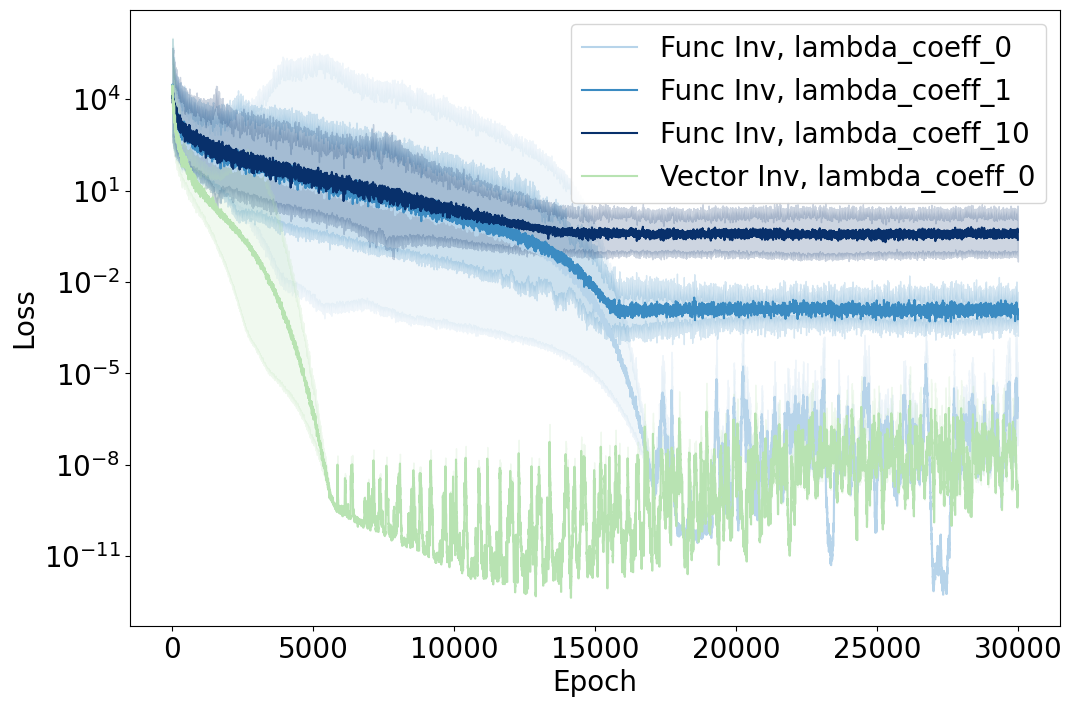

In [8]:
experiment_losses = {}

for idx, diffeo_flow in enumerate(diffeo_flows):
    losses = compute_mean_and_std_losses(diffeo_flow)
    experiment_losses[f'lambda_coeff_{LAMBDA_COEFFS[idx]}'] = losses

plot_experiment_losses(experiment_losses, plot_func_inv=True, plot_vec_field_inv=False)

## Symmetry Discovery + Learning the Diffeomorphism

In [ ]:
N_TASKS = 5
task_angles = torch.linspace(0, 2 * torch.pi, N_TASKS, dtype=torch.float32)

def kernel_distribution_callable(angle):
    """Returns the Kernel Distribution of the reward function after rotating by angle angle in radians."""
    return torch.tensor([
        [(LAMBDA - RHO) * torch.cos(angle) * torch.sin(angle),
         -LAMBDA * torch.sin(angle) ** 2 - RHO * torch.cos(angle) ** 2],
        [LAMBDA * torch.cos(angle) ** 2 + RHO * torch.sin(angle) ** 2,
         (LAMBDA - RHO) * torch.cos(angle) * torch.sin(angle)]
    ], dtype=torch.float32)